In [1]:
%matplotlib ipympl
import pickle
from typing import Iterable, Callable

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

from simulate_dicke import sim_dicke


In [2]:
latex_textwidth = 0.01384 * 434

In [3]:
def plot_sim_dicke(
    N: int,
    T: float,
    n: int = 0,
    freq: float = 1.0,
    coup: float = 1.0,
    time_step=None,
    spin_state_name="excited",
):
    """
    Only for quick simulations.
    """
    tt, vt, et, duration = sim_dicke(
        N=N,
        T=T,
        n=n,
        freq=freq,
        coup=coup,
        time_step=time_step,
        spin_state_name=spin_state_name,
    )
    plt.scatter(tt, np.real_if_close(et[0]), s=10)
    plt.xlabel("t")
    plt.ylabel("$\\langle v(t), \\hat n v(t)\\rangle$")
    plt.title(f"N={N}")
    plt.show()

In [4]:
# with open("dicke_sim_09_01_2025-16_19_05_N-2-20_T-6.0.pickle", "rb") as file:
#     data = pickle.load(file)

with open(
    "dicke_sim_09_01_2025-17_04_45_excited_N-2-60_T-6.0.pickle", "rb"
) as file:
    data_excited_long = pickle.load(file)

with open(
    "dicke_sim_13_01_2025-12_59_32_excited_N-2-60_T-3.0.pickle", "rb"
) as file:
    data_excited = pickle.load(file)

with open(
    "dicke_sim_10_01_2025-14_46_06_superradiant_N-2-60_T-6.0.pickle", "rb"
) as file:
    data_superradient_long = pickle.load(file)

with open(
    "dicke_sim_14_01_2025-11_24_23_superradiant_N-2-60_T-3.0.pickle", "rb"
) as file:
    data_superradient = pickle.load(file)


In [28]:
ylabel_dict = {
    "expect": {
        "superradiant": r"$n_{\text{sup}}(t)$",
        "excited": r"$n_{\text{exc}}(t)$",
    },
    "variance": {
        "superradiant": "$\\sigma^2_{\\text{sup}}(t)$",
        "excited": "$\\sigma^2_{\\text{exc}}(t)$",
    },
    "slopes": {
        "superradiant": "$\\frac{\\Delta_{\\text{sup}}(t)}{\\mathrm{d}t}$",
        "excited": "$\\frac{\\Delta_{\\text{exc}}(t)}{\\mathrm{d}t}$",
    },
}


def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        "trunc({n},{a:.2f},{b:.2f})".format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)),
    )
    return new_cmap


def slope(x1, y1, x2, y2) -> float:
    return (y2 - y1) / (x2 - x1)


def arr_slope(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    y1 = y[:-1]
    x1 = x[:-1]
    y2 = y[1:]
    x2 = x[1:]

    return slope(x1, y1, x2, y2)


def plot_data(
    data: list[dict],
    max_N: int = None,
    min_N: int = None,
    N_selection: Iterable = None,
    y: tuple = (None, None),
    x: tuple = (None, None),
    metric: str = "expect",
    set_colorbar: bool = True,
    use_larger_font: bool = False,
    width=latex_textwidth,
):
    if use_larger_font:
        plt.style.use("mpl_large.style")
    if not use_larger_font:
        plt.style.use("mpl_small.style")

    if metric == "slopes":
        ys = np.array([np.real(res["st"][0]) for res in data])[::-1]
        xs = np.array([res["tt"][:-1] for res in data])[::-1]

    if metric == "variance":
        ys = np.array([np.real(res["et"][1]) for res in data])[::-1]
        xs = np.array([res["tt"] for res in data])[::-1]

    if metric == "expect":
        ys = np.array([np.real(res["et"][0]) for res in data])[::-1]
        xs = np.array([res["tt"] for res in data])[::-1]

    Ns = np.array([res["N"] for res in data])[::-1]

    state_name = data[0]["spin_state"]
    # if plot_slopes:
    #     # change to derivative approximation
    #     ys = np.array([arr_slope(x, y) for x, y in zip(xs, ys)])
    #     xs = np.array([x[:-1] for x in xs])

    min_x, max_x = x
    min_y, max_y = y

    if max_N is None:
        max_N = max(Ns)
    if min_N is None:
        min_N = min(Ns)

    # apriori filter for everything
    filter = np.logical_and(Ns <= max_N, min_N <= Ns)

    xs = xs[filter]
    ys = ys[filter]
    Ns = Ns[filter]

    fig, ax = plt.subplots()
    # fig.set_size_inches(8, 4)
    fig.set_layout_engine("tight")
    w, h = fig.get_size_inches()
    aspectratio = h / w
    fig.set_size_inches(width, width * aspectratio, forward=False)

    # ['viridis', 'plasma', 'inferno', 'magma', 'cividis']

    cmap = truncate_colormap(mpl.cm.viridis, 0.2, 0.92, len(ys))
    colors = cmap(np.linspace(0, 1, len(ys)))

    # a posterori filter just for the selection of graphs, colors are unaffected
    if N_selection is not None:
        selection_filter = np.isin(Ns, N_selection)
    if N_selection is None:
        selection_filter = np.ones_like(Ns)

    if metric == "slopes":
        ax.axhline(y=0, xmin=0, xmax=1, color="black")

    for N, x, y, c, f in zip(Ns, xs, ys, colors, selection_filter):
        if f:
            ax.plot(
                x[:: int(len(x) / 1000)],
                y[:: int(len(x) / 1000)],
                "o-",
                alpha=0.6,
                # linewidth=1.5,
                # markeredgewidth=1,
                markersize=1,
                label=f"N={N}",
                color=c,
            )
    ax.set_xlabel("t")
    # ax.set_ylabel("$\\langle v(t), \\hat n v(t)\\rangle$")
    # ax.set_ylabel("$\\langle \\hat n\\rangle_{v(t)}$")
    ax.set_ylabel(ylabel_dict[metric][state_name])

    if max_y is not None and min_y is not None:
        ax.set_ylim(min_y, max_y)
    if max_x is not None and min_x is not None:
        ax.set_xlim(min_x, max_x)
    else:
        ax.set_xlim(np.min(xs[0]), np.max(xs[0]))

    # x_ticks = list(ax.get_xticks())
    # x_ticks.append(xs[0][-1])
    # ax.set_xticks = np.arange(min(xs[0]), max(xs[0]), 0.1)
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))

    if set_colorbar:
        bounds = Ns
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        cbar = fig.colorbar(
            mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
            # label="N",
            ax=ax,
            orientation="vertical",
            # fraction=0.2,
            aspect=10,
            # ticks=Ns,
        )
        cbar.ax.set_xlabel("N", rotation="horizontal")

        # # always add highest N to ticks
        # cbar_ticks = list(cbar.get_ticks())
        # cbar_ticks.append(Ns[-1])
        # if cbar_ticks[-1] - cbar_ticks[-2] <= 4:
        #     cbar_ticks.pop(-2)
        if np.max(Ns) >= 20:
            cbar_ticks = list(range(10, np.max(Ns), 10))
        cbar_ticks.append(np.max(Ns))
        cbar_ticks.insert(0, np.min(Ns))
        # filter ticks for selected graphs
        if N_selection is not None:
            cbar_ticks = N_selection

        cbar.set_ticks(np.array(cbar_ticks))

    return fig


In [6]:
# compute slopes and add to data
for data in [data_excited, data_superradient]:
    for res in data:
        res["st"] = list()
        for et in res["et"]:
            yt = np.real_if_close(np.array(et))
            xt = np.array(res["tt"])
            # change to derivative approximation
            slopes = arr_slope(xt, yt)
            res["st"].append(slopes)

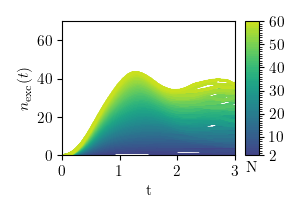

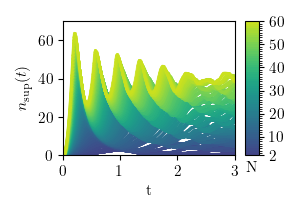

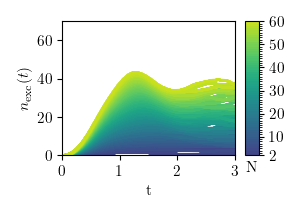

In [30]:
fig_excited = plot_data(
    data_excited,
    # max_N=43,
    # x=(0, 6),
    y=(0, 70),
    width=latex_textwidth * 0.5,
    # use_larger_font=True,
)

fig_superradiant = plot_data(
    data_superradient,
    # max_N=43,
    # x=(0, 6),
    y=(0, 70),
    width=latex_textwidth * 0.5,
    # use_larger_font=True,
)

fig_excited.savefig(
    "figures/fig_excited.pdf", bbox_inches="tight", format="pdf"
)
fig_excited.savefig(
    "figures/fig_excited.svg", bbox_inches="tight", format="svg"
)

fig_superradiant.savefig(
    "figures/fig_superradiant.pdf", bbox_inches="tight", format="pdf"
)
fig_superradiant.savefig(
    "figures/fig_superradiant.svg", bbox_inches="tight", format="svg"
)

fig_excited.show()
fig_superradiant.show()

plt.close()
# fig2 = plot_data(data_excited, max_N=43, x=(0, 3))
# fig3 = plot_data(data_excited, max_N=43, x=(0, 2))

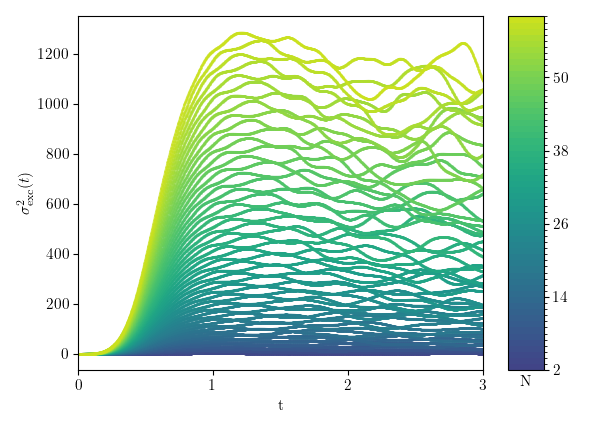

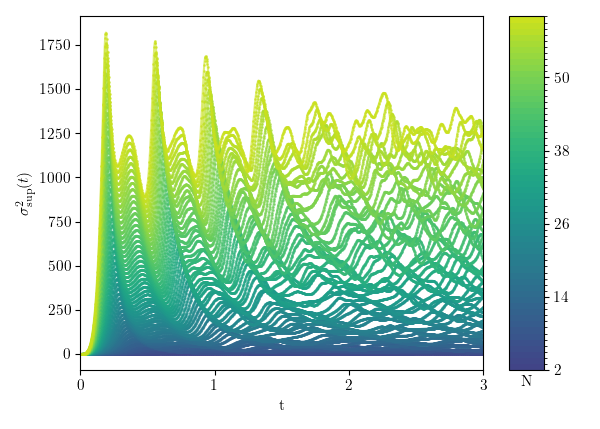

In [8]:
fig_excited = plot_data(
    data_excited,
    # max_N=43,
    # x=(0, 6),
    # y=(0, 66),
    metric="variance",
)
fig_superradiant = plot_data(
    data_superradient,
    # max_N=43,
    # x=(0, 6),
    # y=(0, 66),
    metric="variance",
)


- consider steepness of initial slope
- consider highpoint of initial slope
- consider average after initial slope


Above N=43 there are numerical artifacts. Possibly need to increase time_step


In [9]:
# compute slopes and add to data
for data in [data_excited, data_superradient]:
    for res in data:
        res["st_sign_change"] = list()
        for st in res["st"]:
            sign_slope = np.sign(res["st"][0])
            sign_change = np.sign(sign_slope[:-1] - sign_slope[1:])
            res["st_sign_change"].append(sign_change)

In [10]:
# compute average after first slope
for data in [data_excited, data_superradient]:
    for res in data:
        res["avg after first bump"] = list()
        for et, st, st_sign_change in zip(
            res["et"], res["st"], res["st_sign_change"]
        ):
            # get first non zero
            first_sign_change = (st_sign_change != 0).argmax(axis=0)
            after_first_bump = et[first_sign_change:]
            res["avg after first bump"].append(np.average(after_first_bump))

In [11]:
# quadratic fit onto the slope
def quadratic_poly(x: float, a: float, b: float, c: float, d: float):
    return a * (x - d) ** 2 + b * (x - d) + c


def quadratic_linear(x, a, b):
    return a * x**2 + b * x


def quadratic_linear_std(x, a_std, b_std):
    return np.sqrt(a_std**2 * np.abs(x**2) + b_std**2 * np.abs(x))


def linear(x, a):
    return a * x


def linear_std(x, a_std):
    return a_std * np.abs(x)


def quadratic(x, a):
    return a * x**2


def quadratic_std(x, a_std):
    return a_std * np.abs(x**2)

In [12]:
marker_dict = {"superradiant": "o", "excited": "^"}
label_dict = {
    "avg after first bump": "Average photon expectation value after first bump",
    "first high": "Maximal photon expectation value during first bump",
    "first slope": "Slope of first bump",
    "initial slope": "Slope over short time of 0.1",
}
color_dict = {"superradiant": "limegreen", "excited": "dodgerblue"}  # orangered


def plot_data_N_dependence(
    data_list,
    metric: str,
    max_N: int = None,
    min_N: int = None,
    fit_function: Callable | None = None,
    fit_function_std: Callable | None = None,
    initial_fit_parameters: tuple | None = None,
):
    fig, ax = plt.subplots()
    fig.set_layout_engine("constrained")
    w, h = fig.get_size_inches()
    aspectratio = h / w
    width = 8
    fig.set_size_inches(width, width * aspectratio, forward=False)

    for data in data_list:
        Ns = np.array([res["N"] for res in data])[::-1]

        if max_N is None:
            max_N = max(Ns)
        if min_N is None:
            min_N = min(Ns)
        # apriori filter for everything
        filter = np.logical_and(Ns <= max_N, min_N <= Ns)

        y = np.array([np.real_if_close(res[metric][0]) for res in data])[::-1]
        x = np.array([res["N"] for res in data])[::-1]
        state_name = data[0]["spin_state"]
        if fit_function is not None:
            x_data = x[filter]
            y_data = y[filter]
            # sigma = 0.01 * y_data
            popt, pcov = curve_fit(
                fit_function,
                x_data,
                y_data,
                initial_fit_parameters,
                # sigma=sigma,
            )
            pstd = np.sqrt(np.diag(pcov))
            # r = y_data - fit_function(x_data, *popt)
            # chisq = sum((r / sigma) ** 2)
            # x_fit = np.linspace(np.min(x_data), np.max(x_data), 1000)
            x_fit = x_data
            y_fit = fit_function(x_fit, *popt)
            ax.plot(
                x_fit,
                y_fit,
                alpha=0.6,
                linewidth=3,
                color=color_dict[state_name],
                # label="{}*(x-{})^2 + {}*x + {}".format(*np.round(popt, 2)),
                label=f"{fit_function.__name__} fit",
                # zorder=-1,
            )
            print(
                f"Fit Result for {state_name} state with {fit_function.__name__} fit:"
            )
            alphabet = "abcdefghijklmnopqrstuvwxyz"
            for a, p, err in zip(alphabet, popt, pstd):
                print(f"{a} = {p} \\pm {err}")

            if fit_function_std is not None:
                y_fit_std = fit_function_std(x_fit, *pstd)
                ax.fill_between(
                    x_fit,
                    y_fit + y_fit_std,
                    y_fit - y_fit_std,
                    alpha=0.3,
                    color=color_dict[state_name],
                )
        ax.scatter(
            x[filter],
            y[filter],
            # c=x[filter],
            # cmap=mpl.cm.viridis,
            color=color_dict[state_name],
            alpha=1,
            marker=marker_dict.get(state_name, "."),
            # marker="$f=ma$",
            s=35,
            # s=2000,
            label=f"{state_name} state",
        )

    ax.legend()
    ax.set_xlabel("N")
    ax.set_ylabel(label_dict[metric])
    return fig

Fit Result for superradiant state with linear fit:
a = 0.6722325622697195 \pm 0.0007819420184153547
Fit Result for excited state with linear fit:
a = 0.6217369032495699 \pm 0.001834045172669849


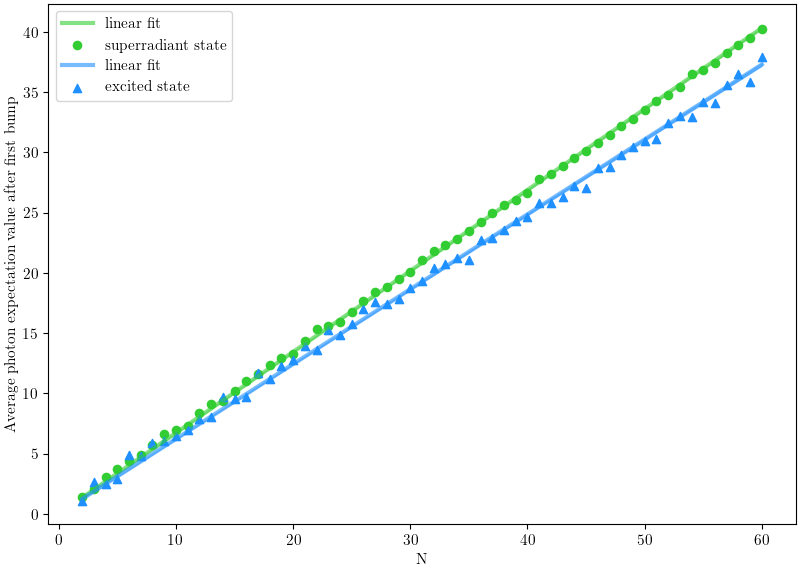

In [13]:
fig_avg_after_first_bump = plot_data_N_dependence(
    [data_superradient, data_excited],
    "avg after first bump",
    # max_N=43,
    fit_function=linear,
    fit_function_std=linear,
    initial_fit_parameters=(1,),
)
fig_avg_after_first_bump.savefig(
    "figures/fig_avg_after_first_bump.pdf", bbox_inches="tight", format="pdf"
)
fig_avg_after_first_bump.savefig(
    "figures/fig_avg_after_first_bump.svg", bbox_inches="tight", format="svg"
)


In [14]:
# compute highest value of first bump
for data in [data_excited, data_superradient]:
    for res in data:
        res["first high"] = list()
        for et, st, st_sign_change in zip(
            res["et"], res["st"], res["st_sign_change"]
        ):
            # get first non zero
            first_sign_change = (st_sign_change != 0).argmax(axis=0)
            first_bump = et[: first_sign_change + 1]
            max_in_first_bump = np.max(first_bump)

            res["first high"].append(max_in_first_bump)

Fit Result for excited state with linear fit:
a = 0.7268202680611687 \pm 0.0007107796346766562
Fit Result for superradiant state with linear fit:
a = 1.0668130957009758 \pm 0.0009136607008811571


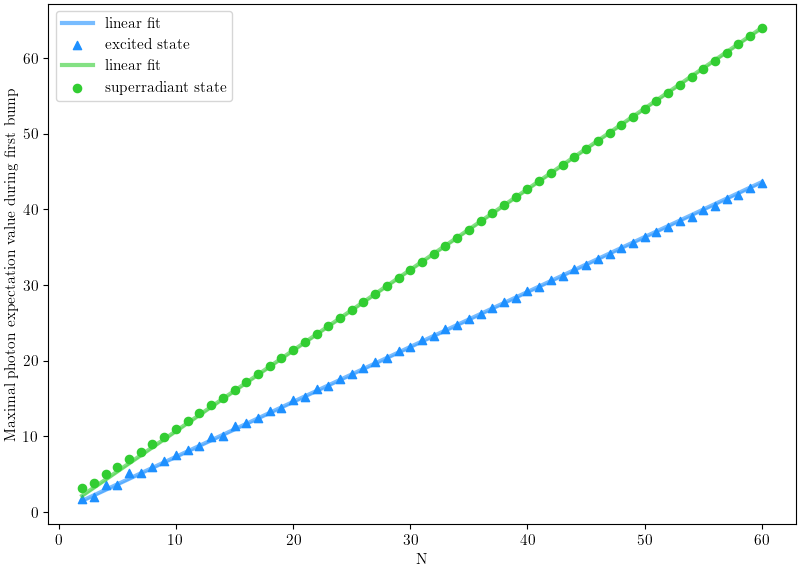

In [15]:
fig_high_of_first_bump = plot_data_N_dependence(
    [data_excited, data_superradient],
    "first high",
    # max_N=43,
    fit_function=linear,
    fit_function_std=linear_std,
    initial_fit_parameters=(1,),
)
fig_high_of_first_bump.savefig(
    "figures/fig_high_of_first_bump.pdf", bbox_inches="tight", format="pdf"
)
fig_high_of_first_bump.savefig(
    "figures/fig_high_of_first_bump.svg", bbox_inches="tight", format="svg"
)


In [16]:
# compute total slope of first bump
for data in [data_excited, data_superradient]:
    for res in data:
        res["first slope"] = list()
        for et, st_sign_change in zip(res["et"], res["st_sign_change"]):
            # get first non zero
            first_sign_change = (st_sign_change != 0).argmax(axis=0)
            first_bump = et[: first_sign_change + 1]
            max_in_first_bump = np.max(first_bump)
            t_of_max_in_first_bump = res["tt"][np.argmax(first_bump)]
            res["first slope"].append(
                max_in_first_bump / t_of_max_in_first_bump
            )

Fit Result for superradiant state with quadratic_linear fit:
a = 0.05428864079513873 \pm 0.0007074698870381038
b = 2.0755480283627485 \pm 0.03315181345720976
Fit Result for excited state with quadratic_linear fit:
a = 0.0022698408806036685 \pm 0.00011126574088019643
b = 0.43617122729014246 \pm 0.005213877214335107


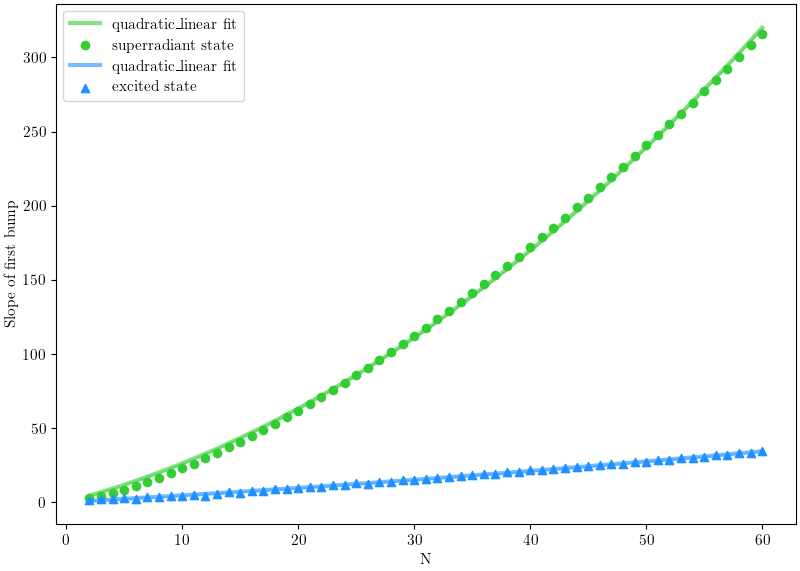

In [17]:
fig_slope_of_first_bump = plot_data_N_dependence(
    [data_superradient, data_excited],
    "first slope",
    # max_N=43,
    fit_function=quadratic_linear,
    fit_function_std=quadratic_linear_std,
    initial_fit_parameters=(1, 0),
)

fig_slope_of_first_bump.savefig(
    "figures/fig_slope_of_first_bump.pdf", bbox_inches="tight", format="pdf"
)
fig_slope_of_first_bump.savefig(
    "figures/fig_slope_of_first_bump.svg", bbox_inches="tight", format="svg"
)


In [18]:
# compute total slope for short time
for data in [data_excited, data_superradient]:
    for res in data:
        res["initial slope"] = list()
        for et, st_sign_change in zip(res["et"], res["st_sign_change"]):
            # get first non zero
            # first_sign_change = (st_sign_change != 0).argmax(axis=0)
            # selection = et[: np.int32(np.round(first_sign_change / 10))]
            selection = et[: (np.array(res["tt"]) >= 0.1).argmax(axis=0)]
            max_in_selection = np.max(selection)
            t_of_max_in_selection = res["tt"][np.argmax(selection)]
            res["initial slope"].append(
                max_in_selection / t_of_max_in_selection
            )

Fit Result for superradiant state with quadratic_linear fit:
a = 0.049224119924596105 \pm 8.152407853416183e-06
b = 0.09674597132327903 \pm 0.0003820192416228515
Fit Result for excited state with quadratic_linear fit:
a = -5.247194234669905e-08 \pm 2.8187448783593086e-13
b = 0.09848200922074862 \pm 1.32083699733429e-11


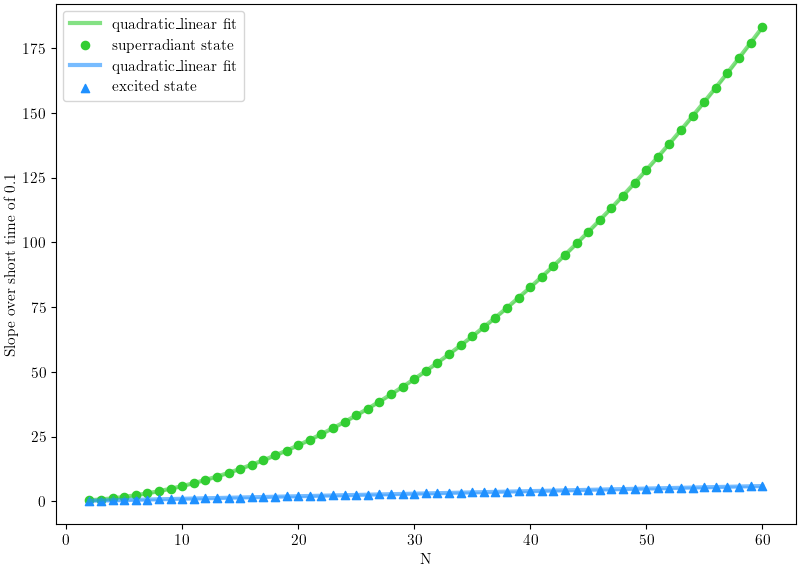

In [19]:
fig_slope_short_time = plot_data_N_dependence(
    [data_superradient, data_excited],
    "initial slope",
    # max_N=43,
    fit_function=quadratic_linear,
    fit_function_std=quadratic_linear_std,
    initial_fit_parameters=(1, 0),
)

fig_slope_short_time.savefig(
    "figures/fig_slope_short_time.pdf", bbox_inches="tight", format="pdf"
)
fig_slope_short_time.savefig(
    "figures/fig_slope_short_time.svg", bbox_inches="tight", format="svg"
)

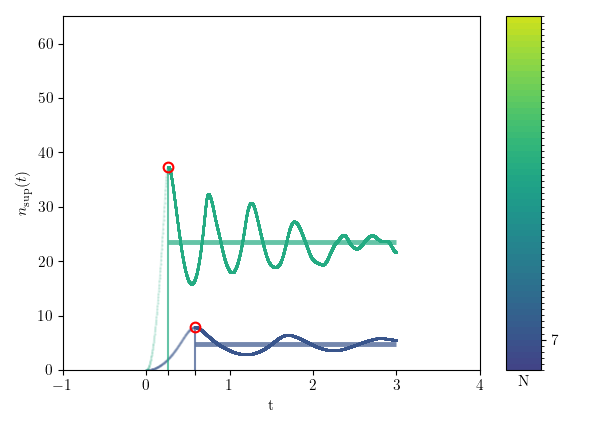

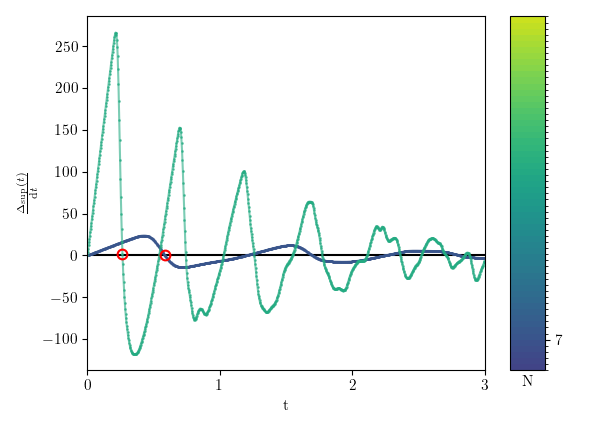

In [20]:
demonstration_selection = [7, 35]
fig_demo = plot_data(
    data_superradient,
    # max_N=43,
    N_selection=demonstration_selection,
    # x=(0, 6),
    y=(0, 65),
)

slopes_demos = plot_data(
    data_superradient,
    # x=(0, 6),
    # max_N=43,
    N_selection=demonstration_selection,
    metric="slopes",
)

for i, N in enumerate(demonstration_selection):
    res_demo = data_superradient[-(N - 1)]

    assert res_demo["N"] == N, f"{res_demo['N']},  {N}"

    sign_change = res_demo["st_sign_change"][0]

    axes = fig_demo.get_axes()
    ax = axes[0]

    first_sign_change = (sign_change != 0).argmax(axis=0)
    after_first_bump = res_demo["et"][0][first_sign_change:]
    t_after_first_bump = res_demo["tt"][first_sign_change:]

    # filter = sign_change != 0
    filter = first_sign_change

    lines = ax.get_lines()
    line = lines[i]
    line.set_alpha(0.1)
    color = line.get_color()

    ax.plot(
        t_after_first_bump,
        np.real_if_close(after_first_bump),
        "o",
        color=color,
        markersize=line.get_markersize(),
        markeredgewidth=line.get_markeredgewidth(),
    )

    ax.hlines(
        y=np.real_if_close(res_demo["avg after first bump"][0]),
        xmin=min(t_after_first_bump),
        xmax=max(t_after_first_bump),
        linewidths=3.5,
        alpha=0.7,
        colors=color,
        label=f"Average after initial slope for N={N}",
    )

    ax.vlines(
        x=np.array(res_demo["tt"][:-2])[first_sign_change],
        ymin=0,
        ymax=np.real_if_close(
            np.array(res_demo["et"][0])[:-2][first_sign_change]
        ),
        colors=color,
        alpha=0.7,
    )

    ax.plot(
        np.array(res_demo["tt"][:-2])[filter],
        np.real_if_close(np.array(res_demo["et"][0])[:-2][filter]),
        "o",
        markersize=7,
        markeredgewidth=1.5,
        markerfacecolor="none",
        color="r",
    )
    ticks = ax.get_xticks()
    tick_labels = ax.get_xticklabels()
    ax.set_xticks(
        np.append(ticks, np.array(res_demo["tt"][:-2])[first_sign_change])
    )
    ax.set_xticklabels(np.append(tick_labels, ""))

    # xtriangle = np.linspace(0, 0.1, 100)
    # ytriangle = np.real_if_close(res_demo["initial slope"] * xtriangle)
    # ax.plot(xtriangle, ytriangle)

    axes_slopes = slopes_demos.get_axes()
    ax_slopes = axes_slopes[0]
    ax_slopes.plot(
        np.array(res_demo["tt"][:-2])[filter],
        np.real_if_close(np.array(res_demo["st"][0])[:-1][filter]),
        "o",
        markersize=7,
        markeredgewidth=1.5,
        markerfacecolor="none",
        color="r",
    )

    ax_slopes.vlines(
        x=np.array(res_demo["tt"][:-2])[first_sign_change],
        ymin=0,
        ymax=np.real_if_close(
            np.array(res_demo["st"][0])[:-2][first_sign_change]
        ),
        colors=color,
        alpha=0.7,
    )


fig_demo.savefig("figures/fig_demo.pdf", bbox_inches="tight", format="pdf")
fig_demo.savefig("figures/fig_demo.svg", bbox_inches="tight", format="svg")

slopes_demos.savefig(
    "figures/fig_slopes_demo.pdf", bbox_inches="tight", format="pdf"
)
slopes_demos.savefig(
    "figures/fig_slopes_demo.svg", bbox_inches="tight", format="svg"
)
